In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/PycharmProjects/rqc_internship/RQC-Robotics-tactile_sensor


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

In [3]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_model_path = path_config['base_model_path']
base_model = torch.load(base_model_path, map_location=device)

In [5]:
pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


video_names = [x for x in os.listdir(pressure_path) if x.endswith('.npy')]
name = video_names[0]
pressure = np.load(jn(pressure_path, name))
signal = np.load(jn(signal_path, name))

In [6]:
predicted_pressure = []
sig_dataloader = DataLoader(signal, batch_size=30)
with torch.no_grad():
    for inputs in sig_dataloader:
        inputs = inputs.to(device)
        base_model.eval()
        outputs = base_model(inputs).cpu()
        predicted_pressure.append(outputs)

predicted_pressure = torch.cat(predicted_pressure).numpy()

In [7]:
def pack_learn_dataset(pres, sign, pred_pre):
    result = []
    for i in range(1, len(pres)):
        input = np.concatenate([
            pred_pre[i].flatten(),
            pred_pre[i-1].flatten(),
            sign[i-1].flatten(), 
            (sign[i] - sign[i-1]).flatten()
        ])
        result.append((input, pres[i]))
    return result

In [8]:
batchsize = config['train']['batch_size']

train_dataset = pack_learn_dataset(pressure, signal, predicted_pressure) 
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)

inp, outp = next(iter(train_dataloader))


In [9]:
name = video_names[1]
pressure = np.load(jn(pressure_path, name))
signal = np.load(jn(signal_path, name))
predicted_pressure = []
sig_dataloader = DataLoader(signal, batch_size=30)
with torch.no_grad():
    for inputs in sig_dataloader:
        inputs = inputs.to(device)
        base_model.eval()
        outputs = base_model(inputs).cpu()
        predicted_pressure.append(outputs)

predicted_pressure = torch.cat(predicted_pressure).numpy()

In [10]:
test_dataset = pack_learn_dataset(pressure, signal, predicted_pressure) 
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)


In [11]:
import models_src
model = models_src.FullyConnectedImprover(inp.shape, outp.shape)
summary(model, inp.shape)
tr = config['train']
optim = torch.optim.Adam(model.parameters(), lr=tr['learning_rate'])
loss_fn = torch.nn.MSELoss()


In [12]:

# training functions


def fit_epoch(model, train_loader, criterion, optimizer, pbar=None):
    running_loss = 0.0
    processed_data = 0
    for inputs, labels in train_loader:
        if pbar is not None:
            pbar.update(1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    return train_loss


def eval_epoch(model, test_loader, criterion, pbar=None):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in test_loader:
        if pbar is not None:
            pbar.update(1)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    return val_loss


def predict(model, test_loader):

    with torch.no_grad():
        result = []
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            result.append(outputs)

    return torch.cat(result).numpy()


def iter_train(train_loader, test_loader, model, epochs, optimizer, criterion):
    with tqdm(total=epochs * (len(train_dataloader) + len(test_dataloader)),
              desc="Learning",
              unit='batch') as pbar:
        for epoch in range(epochs):
            train_loss = fit_epoch(model,
                                   train_loader,
                                   criterion,
                                   optimizer,
                                   pbar=pbar)
            test_loss = eval_epoch(model, test_loader, criterion, pbar=pbar)
            # print("loss", f"{train_loss:.3f}")
            pbar.set_postfix(train_loss=train_loss, test_loss=test_loss)
            yield epoch, (train_loss, test_loss)



In [13]:

# %%
history = []


In [ ]:

# %%
for i, h in iter_train(train_dataloader,
                       test_dataloader,
                       model=model,
                       epochs=5, #config['train']['n_epochs'],
                       optimizer=optim,
                       criterion=loss_fn):
    history.append(h)
    # train_loss, test_loss = zip(*history)
    # if i%10 == 0:
    #     # clear_output(wait=True)
    #     plt.figure(figsize=(12, 8))
    #     plt.plot(train_loss, label="train_loss")
    #     plt.plot(test_loss, label="test_loss")
    #     plt.legend(loc='best')
    #     plt.xlabel("epochs")
    #     plt.ylabel("loss")
    #     plt.show()
    np.savetxt(jn(path_config['reports_path'], 'learning_curve.csv'),
               [['train_loss', 'test_loss']] + history,
               delimiter=',',
               fmt='%s')
    os.system(
        'dvc plots diff gausses_exp --x-label "epochs" --y-label "loss" -q')


In [14]:

train_loss, test_loss = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

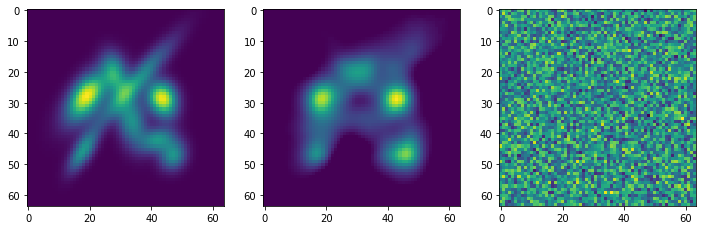

In [15]:
# work visualisation
i = 31
input, pressure = train_dataset[i]
prediction = input[:64*64].reshape(64, 64)
with torch.no_grad():
    improvement = model(torch.tensor(np.expand_dims(input, 0), device=device)).numpy()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(pressure)
plt.subplot(1, 3, 2)
plt.imshow(prediction)
plt.subplot(1, 3, 3)
plt.imshow(improvement[0])

In [16]:
name = video_names[1]
pressure = np.load(jn(pressure_path, name))
signal = np.load(jn(signal_path, name))
predicted_pressure = []
dataloader = DataLoader(list(zip(signal, pressure)), batch_size=30)

eval_epoch(base_model, dataloader, loss_fn)

7945.942471590909

In [17]:
len(signal)

297

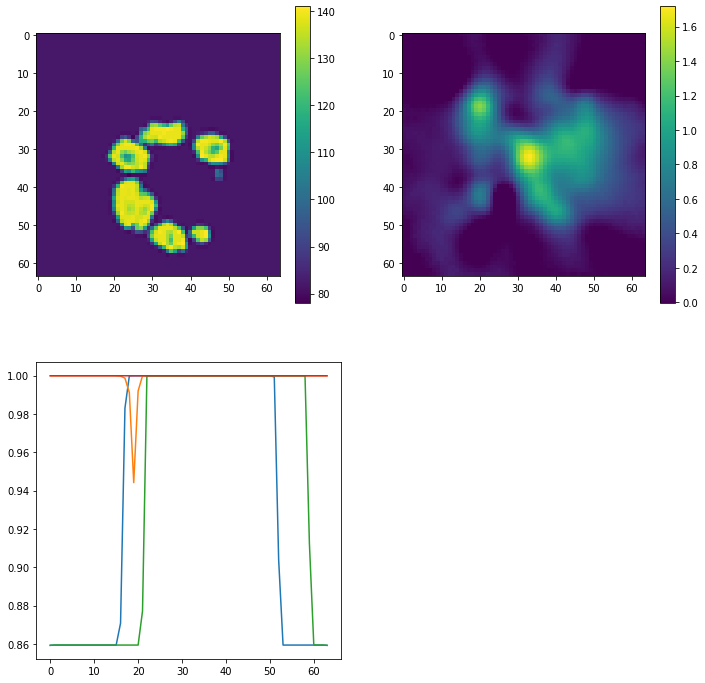

In [29]:
N = 240
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(pressure[N])
plt.colorbar()
with torch.no_grad():
    plt.subplot(2, 2, 2)
    plt.imshow(base_model(torch.tensor(signal[N:N+1]))[0])
    res = base_model(torch.tensor(signal[N:N+1]))[0]
    plt.colorbar()
plt.subplot(2, 2, 3)
plt.plot(np.swapaxes(signal[N], 0, 1))
plt.savefig('../Local research files/real_profile_prediction2.pdf')
plt.show()

In [25]:
import torch_sensor_lib as tsl
s = tsl.FiberSimulator(config)
s.test = True

Rot tensors


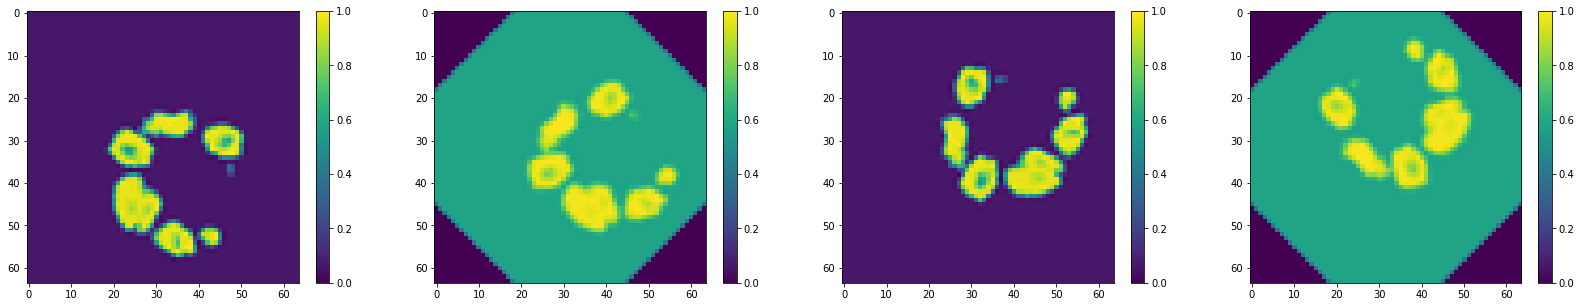

After blur


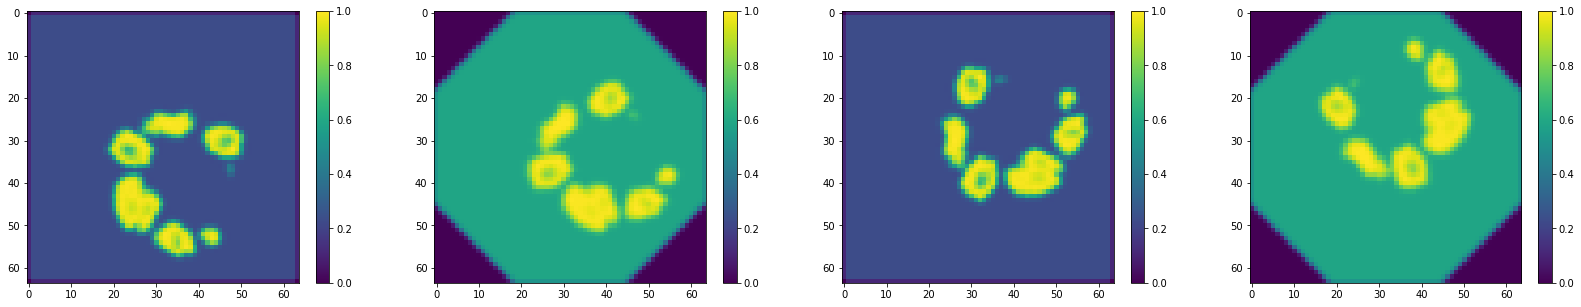

Loss in fiber


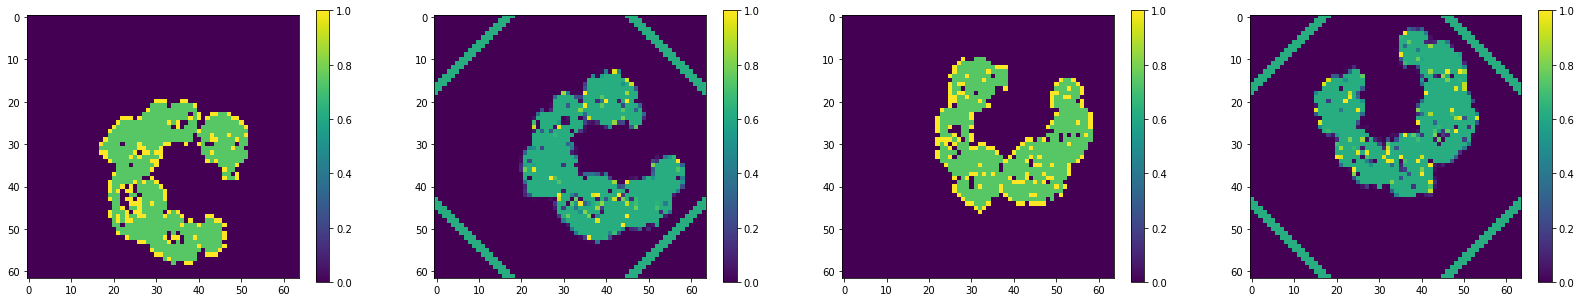

Loss sums


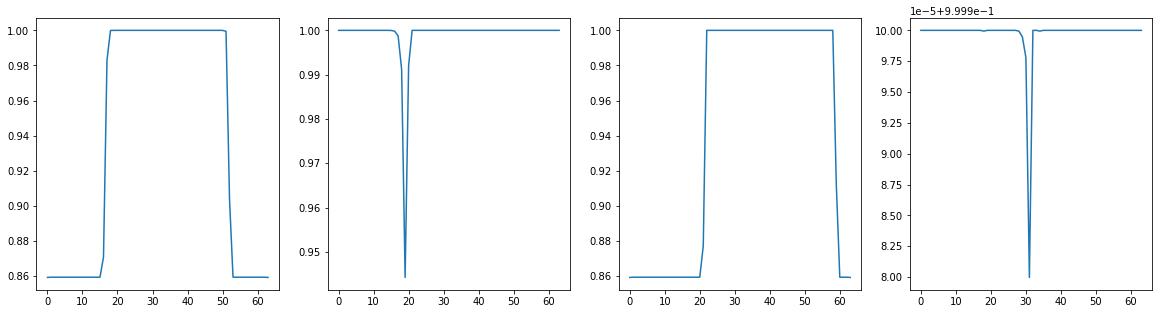

Signal


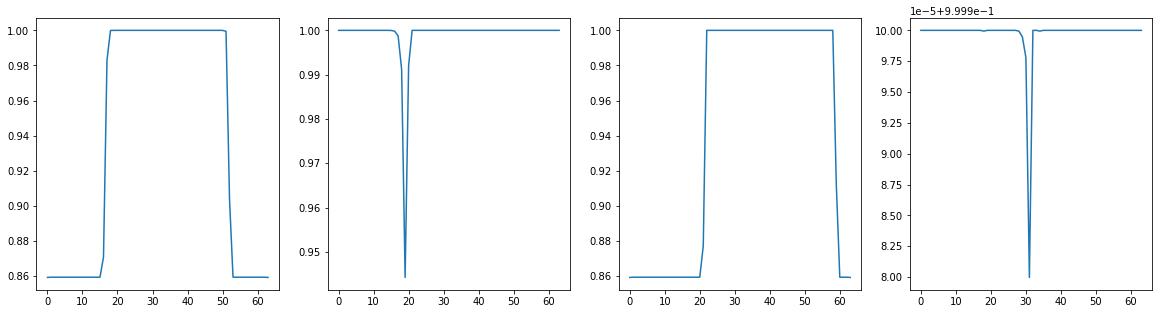

In [32]:
s.fiber_real_sim(pressure[N:N+1]);